##### Explanatory Data Analysis (EDA)

In order to perform explanatory data analysis, cleaned dataset will be pulled from the database.

The following will be performed:
- Connect to the PostgreSQL database using SQLAlchemy.
- Pull data from various tables (ATTACK, DEFENSE, PASSING, SHOOTING, dimension_table) for analysis.
- Performed data cleaning and transformation, including handling missing values and normalizing accented characters.
- Calculate various metrics and percentiles for player performance.
- Visualize data using plots bar plots to see which players are under and overperform their expected golas and assists.
- Automate EDA process by generating distribution plots, scatter plots, and group-by insights.

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import time 
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
# removes warnings
import warnings
warnings.filterwarnings('ignore')
#suppress scientific notation by setting float_format
pd.options.display.float_format = '{:.2f}'.format 
pd.set_option('display.max_rows', None) # display all rows
pd.set_option('display.max_columns', None) # display all columns

#### Connect to the database

In [2]:
load_dotenv()

# Database connection details from environment variables
db_config = {
    'dbname': os.getenv('DB_NAME'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'host': os.getenv('DB_HOST'),
    'port': int(os.getenv('DB_PORT'))  # Ensure the port is correctly converted to an integer
}

# Create a connection string for SQLAlchemy
connection_string = f"postgresql+psycopg2://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['dbname']}"
engine=create_engine(connection_string)

The following features are important in measuring players performance in modern football. so all information will be pulled from a sql database using psycopg2 which is the most popular postgresql adapter of python which helps to combine sql and python.

#### Pull data from database tables

In [3]:
metrics_df = pd.read_sql_query("""WITH dedup_attack AS (
    SELECT player,
           STRING_AGG(DISTINCT squad, ', ') AS squad,
           STRING_AGG(DISTINCT comp, ', ') AS comp,
           SUM(gls)::int AS gls,
           SUM(xg) AS xg,
           SUM(xag) AS xag,
           SUM(ast)::int AS ast,
           SUM(prgc)::int AS prgc
    FROM ATTACK
    GROUP BY player
),
dedup_passing AS (
    SELECT player,
           SUM(kp)::int AS kp,
           SUM(ppa)::int AS ppa,
           SUM(prgp)::int AS prgp,
           AVG(cmp_pcnt) AS cmp_pcnt,
           SUM(pass_into_final_third)::int AS pass_into_final_third
    FROM PASSING
    GROUP BY player
),
dedup_defense AS (
    SELECT player,
           SUM(tkl_plus_int) AS tkl_plus_int,
           SUM(clr) AS clr,
           SUM(blocks) AS blocks
    FROM DEFENSE
    GROUP BY player
),
dedup_shooting AS (
    SELECT player,
           SUM(sot_per_90) AS sot_per_90,
           AVG(sot_pcnt) AS sot_pcnt
    FROM SHOOTING
    GROUP BY player
),
pos_mapping AS (
    SELECT player,
           CASE
               WHEN COALESCE(pos, 'Unknown') IN ('DF', 'DF,FW', 'FW,DF', 'DF,MF') THEN 'defender'
               WHEN COALESCE(pos, 'Unknown') = 'GK' THEN 'goalkeeper'
               ELSE 'mid/att'             
           END AS position
    FROM dimension_table
)
SELECT DISTINCT ON (a.player)  -- Ensure one row per player
    a.player, a.squad, a.comp,
    COALESCE(pm.position, 'Unknown') AS position,
    a.gls, a.ast, a.gls + a.ast AS attacking_contribution,
    ROUND((a.xg + a.xag)::numeric, 1) AS expected_contribution,
    a.prgc, 
    COALESCE(p.kp, 0) AS kp,  -- Handle NULL values
    COALESCE(p.ppa, 0) AS ppa,  
    COALESCE(p.prgp, 0) AS prgp,  
    COALESCE(p.cmp_pcnt, 0) AS cmp_pcnt,  
    COALESCE(p.pass_into_final_third, 0) AS pass_into_final_third,  
    COALESCE(d.tkl_plus_int + d.blocks + d.clr, 0)::int AS defensive_contribution,  
    COALESCE(s.sot_per_90, 0) AS sot_per_90,  
    COALESCE(s.sot_pcnt, 0) AS sot_pcnt 
    
FROM dedup_attack a
LEFT JOIN dedup_passing p ON a.player = p.player
LEFT JOIN dedup_defense d ON a.player = d.player
LEFT JOIN dedup_shooting s ON a.player = s.player
LEFT JOIN pos_mapping pm ON a.player = pm.player
;""",con=engine)


In [6]:
metrics_df.head()

,player,squad,comp,position,gls,ast,attacking_contribution,expected_contribution,prgc,kp,ppa,prgp,cmp_pcnt,pass_into_final_third,defensive_contribution,sot_per_90,sot_pcnt
0,Aaron Ciammaglichella,Torino,it Serie A,mid/att,0,0,0,0.00,0,0,0,0,0.00,0,0,0.00,0.00
1,Aaron Cresswell,West Ham,eng Premier League,defender,0,0,0,0.30,3,5,2,13,78.10,15,31,0.00,0.00
2,Aaron Malouda,Lille,fr Ligue 1,mid/att,0,0,0,0.00,0,0,0,0,0.00,0,0,0.00,0.00
3,Aaron Ramsdale,Southampton,eng Premier League,goalkeeper,0,0,0,0.00,0,0,1,0,65.50,26,10,0.00,0.00
4,Aaron Wan-Bissaka,West Ham,eng Premier League,defender,2,1,3,2.40,68,23,22,92,80.00,70,196,0.17,30.80


Which players are clinical finishers?

In order to do that players goals will be compared with their xG scores. If a player significantly has higher goals than his xg, the player is overperforming or a much better finisher than an average player.

In [19]:
attack=pd.read_sql_query('SELECT * FROM ATTACK',con=engine)
defense=pd.read_sql_query('SELECT * FROM DEFENSE',con=engine)
passing=pd.read_sql_query('SELECT * FROM PASSING',con=engine)
shooting=pd.read_sql_query('SELECT * FROM SHOOTING',con=engine)
dimension=pd.read_sql_query('SELECT * FROM dimension_table', con=engine)

In [7]:
pd.read_sql_query('SELECT player,squad, gls-xg as over_performers FROM ATTACK WHERE gls >=xg+5  ORDER BY 3 DESC',con=engine)

,player,squad,over_performers
0,Mateo Retegui,Atalanta,8.40
1,Chris Wood,Nott'ham Forest,6.70
2,Omar Marmoush,Eint Frankfurt,6.20
3,Bryan Mbeumo,Brentford,6.10
4,Patrik Schick,Leverkusen,5.80
5,Matheus Cunha,Wolves,5.80
6,Ousmane Dembélé,Paris S-G,5.70
7,Lorenzo Lucca,Udinese,5.40
8,Marcus Thuram,Inter,5.30
9,Harry Kane,Bayern Munich,5.20


Mateo Retegui, Chris Wood, Omar Marmoush, Bryan Mbeumo and Patrik Schick are the top five players to overperform their xg by 5 goals or above showing their higher efficiency infront of goals while Abde Ezzalzouli,Breel Embolo, and Tammy Abraham has underperformed their xgs by atleast by 4.

In [8]:
pd.read_sql_query(' SELECT player,squad, xg-gls as under_performers FROM ATTACK WHERE xg >= gls+3  ORDER BY 3 DESC',con=engine).head()

,player,squad,under_performers
0,Abde Ezzalzouli,Betis,6.00
1,Breel Embolo,Monaco,4.40
2,Tammy Abraham,Milan,4.10
3,Takumi Minamino,Monaco,3.60
4,Marco Asensio,Paris S-G,3.60


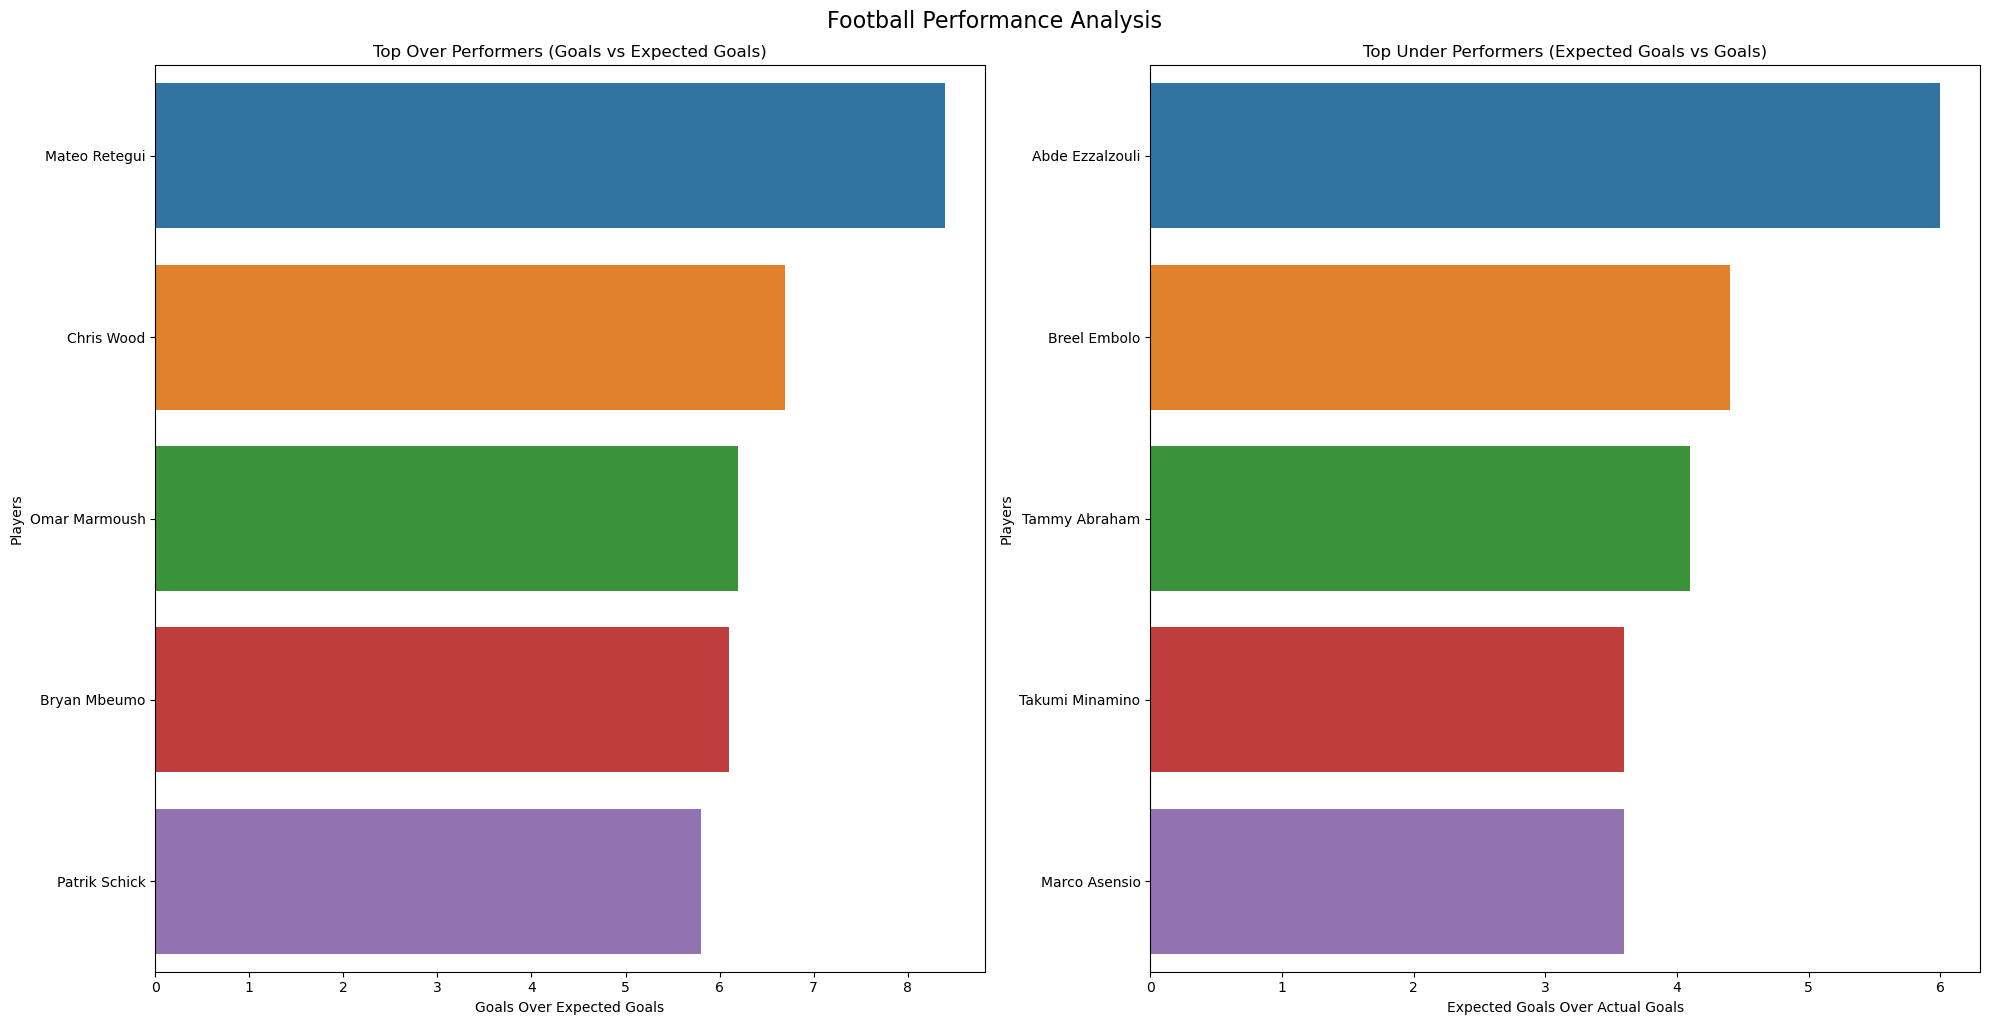

In [9]:
query_over = 'SELECT player, squad, gls-xg as over_performers FROM ATTACK WHERE gls >= xg+5 ORDER BY over_performers DESC'
query_under = 'SELECT player, squad, xg-gls as under_performers FROM ATTACK WHERE xg >= gls+3 ORDER BY under_performers DESC'

df_over = pd.read_sql_query(query_over, con=engine).head()
df_under = pd.read_sql_query(query_under, con=engine).head()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot for over-performers
sns.barplot(x='over_performers', y='player', data=df_over, dodge=False, ax=ax1)
ax1.set_title('Top Over Performers (Goals vs Expected Goals)')
ax1.set_xlabel('Goals Over Expected Goals')
ax1.set_ylabel('Players')

# Plot for under-performers
sns.barplot(x='under_performers', y='player', data=df_under, dodge=False, ax=ax2)
ax2.set_title('Top Under Performers (Expected Goals vs Goals)')
ax2.set_xlabel('Expected Goals Over Actual Goals')
ax2.set_ylabel('Players')
plt.tight_layout()
fig.suptitle('Football Performance Analysis', fontsize=16, y=1.02)
plt.show()

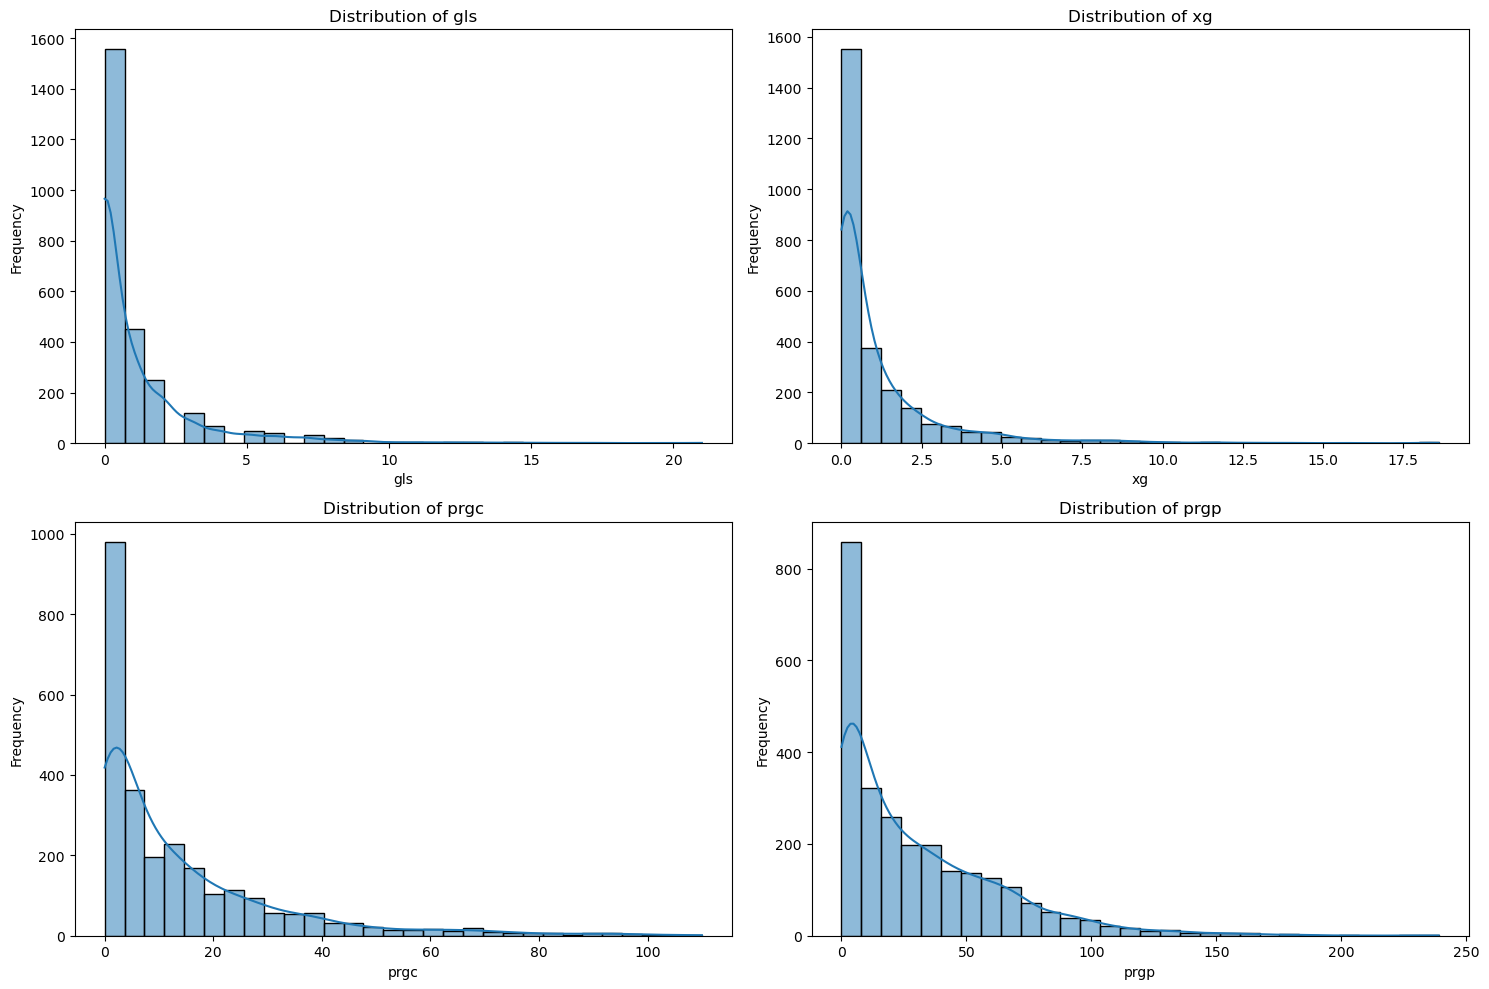

Grouped Statistics by comp:
                    gls  ast   xg  prgp  prgc
comp                                         
de Bundesliga      1.26 0.88 1.20 30.31 12.22
eng Premier League 1.33 0.98 1.35 33.63 17.02
es La Liga         1.02 0.72 1.06 29.70 13.13
fr Ligue 1         1.04 0.69 1.11 28.90 12.91
it Serie A         1.07 0.74 1.02 28.22 13.58
Top 5 Players by gls:
                  player            squad  gls
1203          Harry Kane    Bayern Munich   21
2110       Mohamed Salah        Liverpool   21
2015       Mateo Retegui         Atalanta   20
1010      Erling Haaland  Manchester City   19
1363  Robert Lewandowski        Barcelona   18
Top 5 Players by xg:
                  player            squad    xg
1363  Robert Lewandowski        Barcelona 18.60
1010      Erling Haaland  Manchester City 18.20
2110       Mohamed Salah        Liverpool 18.10
1203          Harry Kane    Bayern Munich 15.80
1550       Kylian Mbappé      Real Madrid 15.20


In [10]:

# Function to load data from PostgreSQL
def load_data_from_db(connection_string, table_name):
    engine = create_engine(connection_string)
    query = f"SELECT * FROM {table_name};"
    df = pd.read_sql(query, con=engine)
    return df

def generate_distribution_subplots(df, columns, ncols=2, figsize=(15, 10)):
   
    # Calculate the number of rows needed
    nrows = (len(columns) + ncols - 1) // ncols

    # Create the subplot grid
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    # Plot distributions
    for i, col in enumerate(columns):
        sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

    # Hide any unused subplots
    for j in range(i + 1, nrows * ncols):
        axes[j].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Function to generate scatter plots
def generate_scatter_plots(df, x_col, y_col):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df[x_col], y=df[y_col])
    plt.title(f'{x_col} vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

# Function to generate group-by insights
def generate_group_by_insights(df, group_col, agg_cols):
    print(f"Grouped Statistics by {group_col}:")
    grouped_stats = df.groupby(group_col)[agg_cols].mean()
    print(grouped_stats)

# Function to generate top players insights
def generate_top_players_insights(df, sort_col, n=10):
    print(f"Top {n} Players by {sort_col}:")
    top_players = df.nlargest(n, sort_col)[['player', 'squad', sort_col]]
    print(top_players)

# Main function to automate EDA
def automate_eda(connection_string, table_name):
    # Load data
    df = load_data_from_db(connection_string, table_name)
    
    # Generate distribution plots for key columns
    numeric_cols = ['gls', 'xg', 'prgc', 'prgp']
    generate_distribution_subplots(df, numeric_cols)
    
    # Generate group-by insights (e.g., by position or league)
    generate_group_by_insights(df, 'comp', ['gls', 'ast', 'xg', 'prgp','prgc'])
    
    # Generate top players insights
    generate_top_players_insights(df, 'gls', n=5)
    generate_top_players_insights(df, 'xg', n=5)

# PostgreSQL connection string
connection_string = f"postgresql+psycopg2://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['dbname']}"

table_name = 'attack'

# Run automated EDA
automate_eda(connection_string, table_name)

Players in the English Premier league have higher number of xGs and actual goals. They also have significantly superir numbers in terms of progresssive carries and passes.

##### Radar Chart

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import PyPizza, add_image, FontManager

Comparison of Kevin De Bruyne among other big 5 European leagues midfielders or attackers.

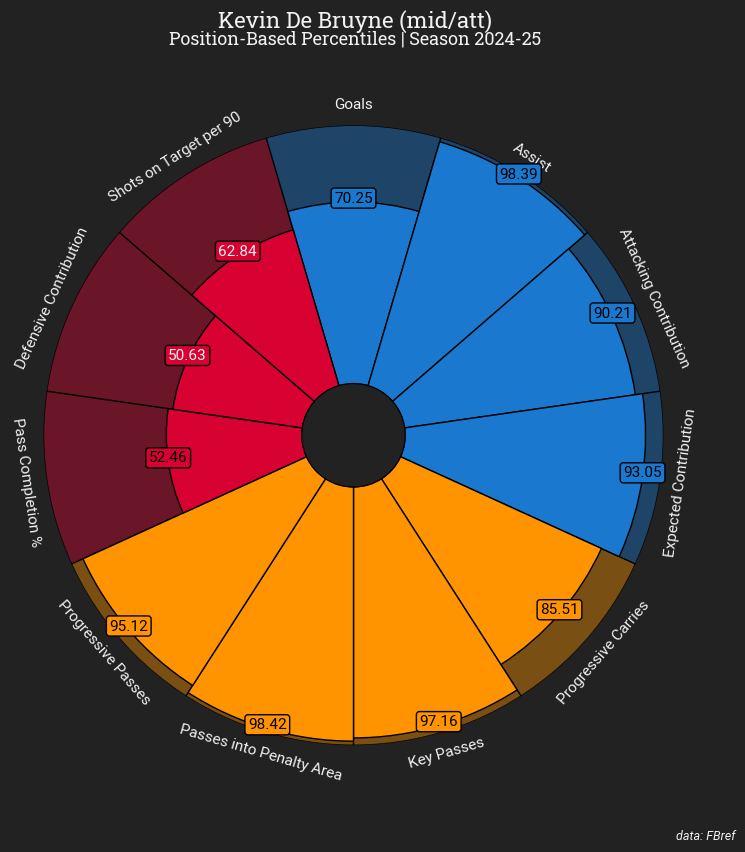

In [61]:
# Define function to compute percentiles within each position group
def compute_position_percentiles(df, position):
    pos_group = df[df['position'] == position]  # Filter by position
    
    for col in [
        'gls', 'ast', 'attacking_contribution', 'expected_contribution', 'prgc', 'kp', 
        'ppa', 'prgp', 'cmp_pcnt', 'defensive_contribution', 'sot_per_90'
    ]:
        percentile_col = f"{col}_percentile"
        df.loc[df['position'] == position, percentile_col] = pos_group[col].rank(pct=True) * 100

    return df

# Apply percentile calculation by position
for pos in metrics_df['position'].unique():
    metrics_df = compute_position_percentiles(metrics_df, pos)

# Select a player
player_name = 'Kevin De Bruyne'
player_data = metrics_df[metrics_df['player'] == player_name].iloc[0]

# Define parameters and values
params = [
    'Goals','Assist','Attacking Contribution','Expected Contribution','Progressive Carries', 
    'Key Passes', 'Passes into Penalty Area', 'Progressive Passes', 'Pass Completion %', 
    'Defensive Contribution', 'Shots on Target per 90'
]
percentile_columns = [
    'gls_percentile', 'ast_percentile', 'attacking_contribution_percentile', 
    'expected_contribution_percentile', 'prgc_percentile', 'kp_percentile', 
    'ppa_percentile', 'prgp_percentile', 'cmp_pcnt_percentile', 
    'defensive_contribution_percentile', 'sot_per_90_percentile'
]

# Fetch percentile values for the selected player
values = [round(player_data[percentile_column], 2) for percentile_column in percentile_columns]

# Fonts
font_normal = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Regular.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Italic.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/RobotoSlab[wght].ttf')

# Slice colors (grouped by attack, midfield, defense)
slice_colors = ["#1A78CF"] * 4 + ["#FF9300"] * 4 + ["#D70232"] * 3
text_colors = ["#000000"] * 9 + ["#F2F2F2"] * 2

# Instantiate PyPizza class
baker = PyPizza(
    params=params,                  
    background_color="#222222",     
    straight_line_color="#000000",  
    straight_line_lw=1,             
    last_circle_color="#000000",    
    last_circle_lw=1,               
    other_circle_lw=0,              
    inner_circle_size=20            
)

# Plot pizza
fig, ax = baker.make_pizza(
    values,                          
    figsize=(8, 8.5),                
    color_blank_space="same",        
    slice_colors=slice_colors,       
    value_colors=text_colors,        
    value_bck_colors=slice_colors,   
    blank_alpha=0.4,                 
    kwargs_slices=dict(
        edgecolor="#000000", zorder=2, linewidth=1
    ),                               
    kwargs_params=dict(
        color="#F2F2F2", fontsize=11,
        fontproperties=font_normal.prop, va="center"
    ),                               
    kwargs_values=dict(
        color="#F2F2F2", fontsize=11,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                             
)

# Add title
fig.text(
    0.515, 0.975, f"{player_name} ({player_data['position']})", size=16,
    ha="center", fontproperties=font_bold.prop, color="#F2F2F2"
)
# Add subtitle
fig.text(
    0.515, 0.955,
    "Position-Based Percentiles | Season 2024-25",
    size=13,
    ha="center", fontproperties=font_bold.prop, color="#F2F2F2"
)
# Add credits
CREDIT_1 = "data: FBref"

fig.text(
    0.99, 0.02, f"{CREDIT_1}", size=9,
    fontproperties=font_italic.prop, color="#F2F2F2",
    ha="right"
)

plt.show()


Performance comparison of selected players in English Premier League 2024/2025 season among other midfielders or attackers

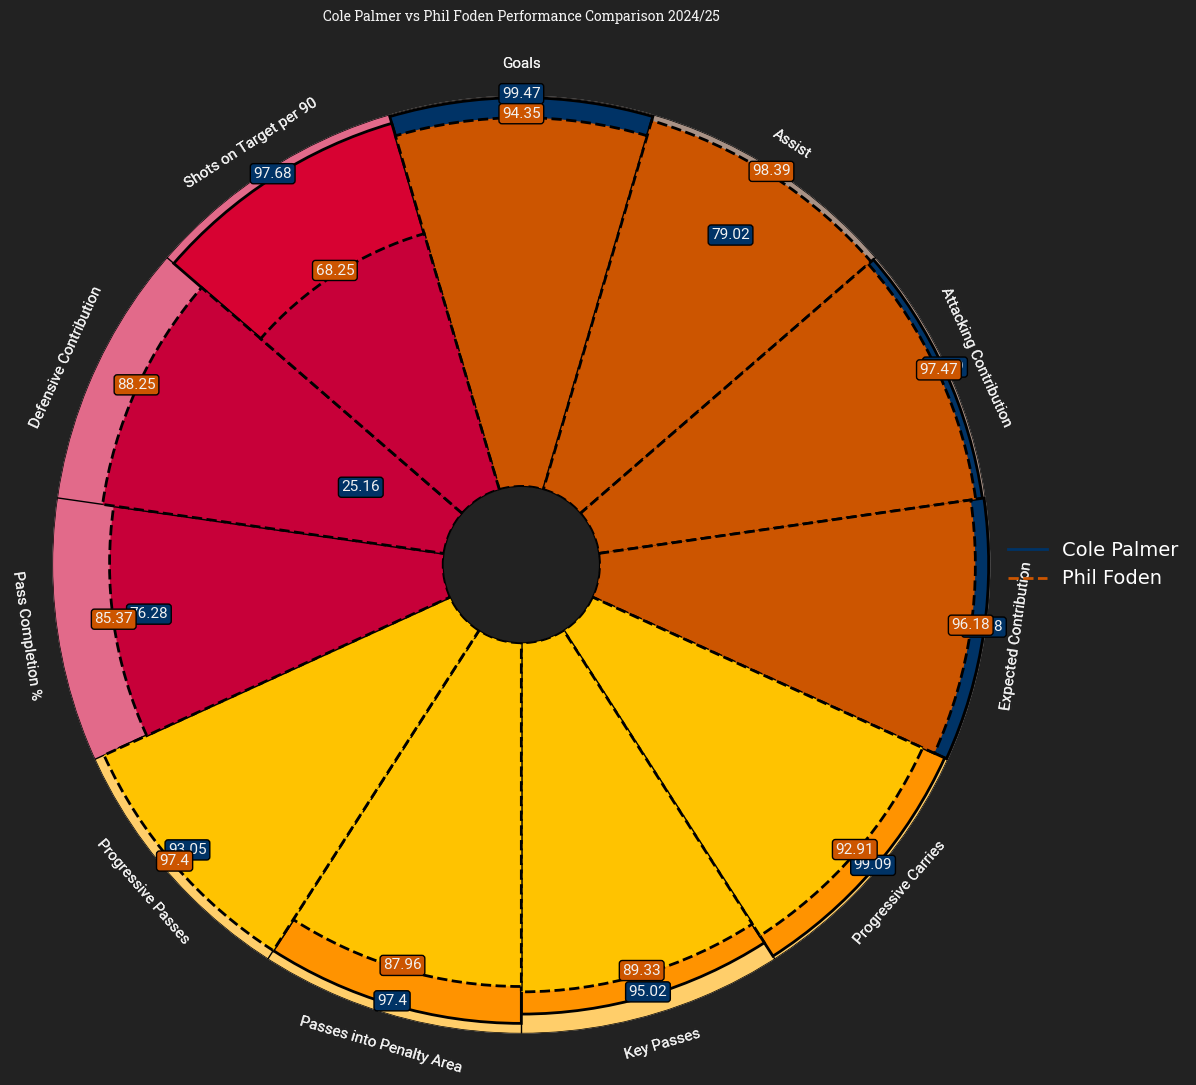

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import PyPizza, FontManager

# Define function to compute percentiles within each position group
def compute_position_percentiles(df, position):
    pos_group = df[df['position'] == position]  # Filter by position
    
    for col in [
        'gls', 'ast', 'attacking_contribution', 'expected_contribution', 'prgc', 'kp', 
        'ppa', 'prgp', 'cmp_pcnt', 'defensive_contribution', 'sot_per_90'
    ]:
        percentile_col = f"{col}_percentile"
        df.loc[df['position'] == position, percentile_col] = pos_group[col].rank(pct=True) * 100

    return df

# Apply percentile calculation by position (assuming 'metrics_df' is defined)
for pos in metrics_df['position'].unique():
    metrics_df = compute_position_percentiles(metrics_df, pos)

# Select two players for comparison
player_names = ['Kylian Mbappé', 'Jude Bellingham']
player_data = metrics_df[metrics_df['player'].isin(player_names)]

# Define parameters and values
params = [
    'Goals', 'Assist', 'Attacking Contribution', 'Expected Contribution', 'Progressive Carries', 
    'Key Passes', 'Passes into Penalty Area', 'Progressive Passes', 'Pass Completion %', 
    'Defensive Contribution', 'Shots on Target per 90'
]
percentile_columns = [
    'gls_percentile', 'ast_percentile', 'attacking_contribution_percentile', 
    'expected_contribution_percentile', 'prgc_percentile', 'kp_percentile', 
    'ppa_percentile', 'prgp_percentile', 'cmp_pcnt_percentile', 
    'defensive_contribution_percentile', 'sot_per_90_percentile'
]

# Fetch percentile values for the selected players
values = [
    [round(player_data[player_data['player'] == name][percentile_column].values[0], 2) 
     for percentile_column in percentile_columns]
    for name in player_names
]

# Fonts
font_normal = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Regular.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/RobotoSlab[wght].ttf')

# Slice colors (custom colors for better distinction with new suggestions)
slice_colors_palmer = ["#003366"] * 4 + ["#FF9300"] * 4 + ["#D70232"] * 3  # Navy blue for Palmer
slice_colors_foden = ["#CC5500"] * 4 + ["#FFC300"] * 4 + ["#C70039"] * 3  # Burnt orange for Foden

# Instantiate PyPizza class
baker = PyPizza(
    params=params,                  
    background_color="#222222",     
    straight_line_color="#000000",  
    straight_line_lw=1,             
    last_circle_color="#000000",    
    last_circle_lw=1,               
    other_circle_lw=0,              
    inner_circle_size=20            
)

# Create figure and axis
fig = plt.figure(figsize=(12, 12), facecolor="#222222")
ax = fig.add_subplot(111, projection='polar')

# Plot pizza for Palmer (solid lines)
baker.make_pizza(
    values[0],                          
    ax=ax,  
    color_blank_space="same",        
    slice_colors=slice_colors_palmer,       
    blank_alpha=0.4,                 
    kwargs_slices=dict(
        edgecolor="#000000", zorder=2, linewidth=2, linestyle="-"
    ),                               
    kwargs_params=dict(
        color="#F2F2F2", fontsize=11,
        fontproperties=font_normal.prop, va="center"
    ),                               
    kwargs_values=dict(
        color="#F2F2F2", fontsize=11,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="#003366",
            boxstyle="round,pad=0.2", lw=1
        )
    )                             
)

# Plot pizza for Foden (dashed lines)
baker.make_pizza(
    values[1],                          
    ax=ax,  
    color_blank_space="same",        
    slice_colors=slice_colors_foden,       
    blank_alpha=0.3,              
    kwargs_slices=dict(
        edgecolor="#000000", zorder=2, linewidth=2, linestyle="--"
    ),                               
    kwargs_params=dict(
        color="#F2F2F2", fontsize=11,
        fontproperties=font_normal.prop, va="center"
    ),                               
    kwargs_values=dict(
        color="#F2F2F2", fontsize=11,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="#CC5500",  
            boxstyle="round,pad=0.2", lw=1
        )
    )                             
)

# Set title with bigger text size
ax.set_title("Cole Palmer vs Phil Foden Performance Comparison 2024/25", 
              fontsize=20, fontproperties=font_bold.prop, color="#F2F2F2", 
              pad=20, loc='center', y=1.05)

# Add legend outside the plot
legend_elements = [
    plt.Line2D([0], [0], color="#003366", lw=2, label='Cole Palmer'),
    plt.Line2D([0], [0], color="#CC5500", lw=2, linestyle="--", label='Phil Foden')
]

# Place legend on the right side of the plot
legend = ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), 
                   frameon=False, fontsize=14, labelcolor='w')

plt.tight_layout()
plt.show()

##### Players' market Valuation

In [14]:
market_df=pd.read_sql_query('SELECT * FROM market', con=engine)

In [46]:
market_df.groupby('main_position')['value'].mean().sort_values(ascending=False)

main_position
Attacking Midfield   17437179.49
Right Winger         16492836.26
Left Winger          14896045.20
Centre-Forward       13766503.27
Defensive Midfield   13000130.89
Central Midfield     12638444.11
Centre-Back          11546428.57
Second Striker       10507142.86
Left Midfield        10108333.33
Left-Back             9801069.52
Right-Back            9065384.62
Right Midfield        8839130.43
Goalkeeper            7779239.77
Sweeper                      NaN
Name: value, dtype: float64

As expected players who play up top of the field have on average a higher market value than the others.

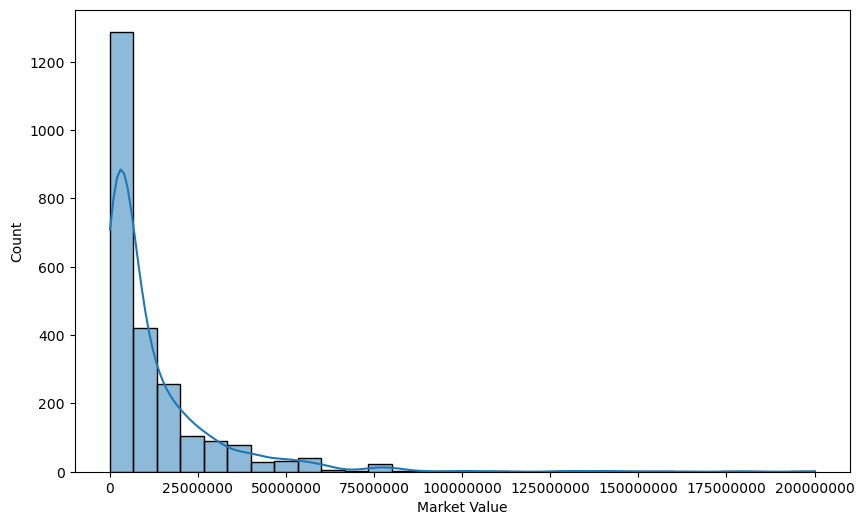

In [16]:
plt.figure(figsize=(10,6))
sns.histplot(data=market_df,x='value',bins=30,kde=True)
plt.ticklabel_format(style='plain')
plt.xlabel('Market Value')
plt.show()

Most of the current players in the big 5 European leagues have a market value less than 50m euros.

In [41]:
analysis_df=pd.read_sql_query(""" select * from prediction """,con=engine )
top_valued_players = analysis_df.nlargest(5, 'value')
top_valued_players[['player_x', 'value']]

,player_x,value
741,Erling Haaland,200000000.00
872,Vinicius Júnior,200000000.00
180,Jude Bellingham,180000000.00
1921,Lamine Yamal,180000000.00
1151,Kylian Mbappé,160000000.00


Vinicius Junior and Erling Haaland are the most highly valued player in European football.

In [60]:
query = """
SELECT league, COUNT(*) AS player_count 
FROM prediction
WHERE value >=100000000
GROUP BY league
"""
pd.read_sql_query(query, con=engine)


,league,player_count
0,Bundesliga,2
1,LaLiga,7
2,Premier League,7
3,Serie A,1


Spanish Laliaga and Premier Leaue (82.35%) have the most number of players valued 100m or above showing star players reside in the two leagues.

#### Player Segmentation Analysis

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def find_similar_players(player_name, df, n_similar=5):
    """
    Find similar players based on performance metrics
    """
    # Define features for similarity calculation
    features = [
        # Performance metrics
        'gls', 'ast', 'xg', 'xag', 'min', 'mp', 'npxg',
        
        # Possession/Passing
        'touches', 'cmp_pcnt', 'prgp', 'kp', 'prgc', 'prgdist', 'ppa',
        'pass_into_final_third', 'carries_into_final_third', 'carries',
        
        # Defensive actions 
        'tkl_plus_int', 'blocks', 'tkl_pcnt', 'clr',
        
        # Shooting
        'sot_pcnt', 'sh_per_90', 'sot_per_90'
    ]
    
    # Create feature matrix
    X = df[features].fillna(0)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Get player index
    try:
        player_idx = df[df['player_x'] == player_name].index[0]
    except IndexError:
        print(f"Player {player_name} not found in database")
        return
    
    # Calculate similarity scores
    similarity_scores = cosine_similarity([X_scaled[player_idx]], X_scaled)[0]
    
    # Get indices of most similar players (excluding self)
    similar_indices = similarity_scores.argsort()[::-1][1:n_similar+1]
    
    print(f"\nMost similar players to {player_name}:")
    print(f"{'Player':<25} {'Club':<20} {'Position':<20} {'Value':<10} {'Similarity':<10}")
    print("-" * 85)
    
    # Print similar players and their details
    for idx in similar_indices:
        player = df.iloc[idx]
        similarity = similarity_scores[idx]
        print(f"{player['player_x']:<25} {player['current_club']:<20} {player['main_position']:<20} {player['value']:<10,.0f} {similarity:.3f}")

# Example usage
example_players = [
    "Erling Haaland",
    "Bruno Fernandes",
    "Bukayo Saka",
    "Rodri",
    "Virgil van Dijk"
]

# Find similar players for each example player
for player in example_players:
    find_similar_players(player, analysis_df)


Most similar players to Erling Haaland:
Player                    Club                 Position             Value      Similarity
-------------------------------------------------------------------------------------
Robert Lewandowski        Barcelona            Centre-Forward       15,000,000 0.991
Moise Kean                Fiorentina           Centre-Forward       30,000,000 0.978
Serhou Guirassy           Bor. Dortmund        Centre-Forward       40,000,000 0.975
Jonathan Burkardt         1.FSV Mainz 05       Centre-Forward       25,000,000 0.974
Yoane Wissa               Brentford            Centre-Forward       28,000,000 0.973

Most similar players to Bruno Fernandes:
Player                    Club                 Position             Value      Similarity
-------------------------------------------------------------------------------------
Enzo Fernández            Chelsea              Central Midfield     75,000,000 0.967
Nicolò Barella            Inter                Central 

#### Scouting and Recruitment

The goal is to find cheaper alternatives to expensive players.

In [43]:
def find_cheaper_alternatives(player_name, df, max_value_ratio=0.5, n_similar=5):
    """
    Find similar but cheaper players compared to a target expensive player.
    
    Args:
        player_name (str): Name of the target expensive player
        df (DataFrame): Player database DataFrame
        max_value_ratio (float): Maximum ratio of target player's value to consider (default 0.5)
        n_similar (int): Number of similar players to return (default 5)
        
    Returns:
        DataFrame with similar cheaper players
    """
    try:
        # Get target player data
        player_idx = df[df['player_x'].str.contains(player_name, case=False, na=False)].index[0]
        player_data = df.iloc[player_idx]
        
        # Get player's value and position
        player_value = player_data['value']
        player_position = player_data['main_position']
        
        # Filter players by position and max value
        position_filter = df['main_position'] == player_position
        value_filter = df['value'] <= (player_value * max_value_ratio)
        candidates = df[position_filter & value_filter].copy()
        
        # Select relevant features for comparison
        features = ['mp', 'starts', 'min', 'gls', 'ast', 'xg', 'xag', 'prgc', 'prgp']
        X = candidates[features]
        
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Calculate similarity scores
        target_vector = scaler.transform(player_data[features].values.reshape(1, -1))
        similarities = cosine_similarity(target_vector, X_scaled)[0]
        
        # Add similarity scores to candidates
        candidates['similarity'] = similarities
        
        # Sort by similarity and get top N
        similar_players = candidates.nlargest(n_similar, 'similarity')
        
        # Print results
        print(f"\nCheaper alternatives to {player_name} (value: {player_value:,.0f}):")
        print(f"{'Player':<25} {'Club':<20} {'Value':<15} {'Similarity':<10}")
        print("-" * 70)
        
        for _, player in similar_players.iterrows():
            print(f"{player['player_x']:<25} {player['current_club']:<20} {player['value']:<15,.0f} {player['similarity']:.3f}")
            
        return similar_players
        
    except IndexError:
        print(f"Player {player_name} not found in database")
        return None

# Example usage
expensive_players = [
    "Erling Haaland",
    "Jude Bellingham", 
    "Declan Rice",
    "Harry Kane"
]

for player in expensive_players:
    find_cheaper_alternatives(player, analysis_df)



Cheaper alternatives to Erling Haaland (value: 200,000,000):
Player                    Club                 Value           Similarity
----------------------------------------------------------------------
Robert Lewandowski        Barcelona            15,000,000      0.969
Moise Kean                Fiorentina           30,000,000      0.966
Serhou Guirassy           Bor. Dortmund        40,000,000      0.964
Jonathan Burkardt         1.FSV Mainz 05       25,000,000      0.960
Emanuel Emegha            R. Strasbourg        15,000,000      0.944

Cheaper alternatives to Jude Bellingham (value: 180,000,000):
Player                    Club                 Value           Similarity
----------------------------------------------------------------------
Andrej Kramarić           TSG Hoffenheim       4,000,000       0.981
Nicolás Paz               Como                 20,000,000      0.944
James Maddison            Tottenham            60,000,000      0.932
Bruno Fernandes           Man Utd

#### Squad Planning

Find potential younger replacements for established football players based on similar playing styles and performance metrics.

The function :
- Determines the player's position

- Filters younger players (under 25 years old) who play in the same position 

- Calculate similarity scores using several key performance metrics:Offensive stats: goals, assists, expected goals, expected assists
Possession/passing metrics: touches, completion percentage, progressive passes
Defensive actions: tackles, interceptions, blocks, clearances
Shooting efficiency: shots on target percentage, shots per 90 minutes

- Uses cosine similarity on standardized features to find players with the most similar playing profile


In [44]:
def find_younger_replacements(player_name, df, max_age=25, n_similar=5):
    """
    Find similar but younger players
    """
    try:
        # Get player data
        player_idx = df[df['player_x'].str.contains(player_name, case=False, na=False)].index[0]
        player_data = df.iloc[player_idx]
        
        # Get player's position
        player_position = player_data['main_position']
        
        # Convert birth_date to datetime properly
        df['birth_date_dt'] = pd.to_datetime(df['born_date'])  # Use 'born_date' instead of 'birth_date'
        
        # Filter for younger players in same position
        today = pd.Timestamp.now()
        max_birth_date = today - pd.DateOffset(years=max_age)
        
        younger_df = df[
            (df['birth_date_dt'] > max_birth_date) &
            (df['main_position'] == player_position)
        ].copy()
        
        if younger_df.empty:
            print(f"No younger players found for position: {player_position}")
            return None
            
        # Define features for similarity calculation
        features = [
            # Performance metrics
            'gls', 'ast', 'xg', 'xag', 'min', 'mp', 'npxg',
            
            # Possession/Passing
            'touches', 'cmp_pcnt', 'prgp', 'kp', 'prgc', 'prgdist', 'ppa',
            'pass_into_final_third', 'carries_into_final_third', 'carries',
            
            # Defensive actions 
            'tkl_plus_int', 'blocks', 'tkl_pcnt', 'clr',
            
            # Shooting
            'sot_pcnt', 'sh_per_90', 'sot_per_90'
        ]
        
        # Create feature matrix
        X = younger_df[features].fillna(0)
        player_vector = df.iloc[player_idx][features].fillna(0).values.reshape(1, -1)
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        player_scaled = scaler.transform(player_vector)
        
        # Calculate similarity scores
        similarity_scores = cosine_similarity(player_scaled, X_scaled)[0]
        
        # Get indices of most similar players
        similar_indices = similarity_scores.argsort()[::-1][:n_similar]
        
        print(f"\nYounger replacements for {player_name} ({player_position}):")
        print(f"{'Player':<25} {'Club':<20} {'Age':<5} {'Value':<15} {'Similarity':<10}")
        print("-" * 75)
        
        # Print similar players and their details
        for idx in similar_indices:
            similar_player = younger_df.iloc[idx]
            age = (today - similar_player['birth_date_dt']).days / 365.25
            similarity = similarity_scores[idx]
            print(f"{similar_player['player_x']:<25} {similar_player['current_club']:<20} {int(age):<5} {similar_player['value']:<15,.0f} {similarity:.3f}")
            
    except IndexError:
        print(f"Player {player_name} not found in database")
        return None
    except Exception as e:
        print(f"Error processing {player_name}: {str(e)}")
        return None

# Example usage
aging_players = [
    "Harry Kane",
    "Mohamed Salah",
    "Kevin De Bruyne",
    "Casemiro",
    "Virgil van Dijk"
]

for player in aging_players:
    find_younger_replacements(player, analysis_df)


Younger replacements for Harry Kane (Centre-Forward):
Player                    Club                 Age   Value           Similarity
---------------------------------------------------------------------------
Benjamin Šeško            RB Leipzig           21    50,000,000      0.824
Georges Mikautadze        Olympique Lyon       24    18,000,000      0.815
Jonathan Burkardt         1.FSV Mainz 05       24    25,000,000      0.808
Nikola Krstović           Lecce                24    6,000,000       0.804
Evann Guessand            OGC Nice             23    20,000,000      0.777

Younger replacements for Mohamed Salah (Right Winger):
Player                    Club                 Age   Value           Similarity
---------------------------------------------------------------------------
Mason Greenwood           Marseille            23    35,000,000      0.853
Noni Madueke              Chelsea              22    40,000,000      0.811
Lamine Yamal              Barcelona            17   

#### Radar Plot

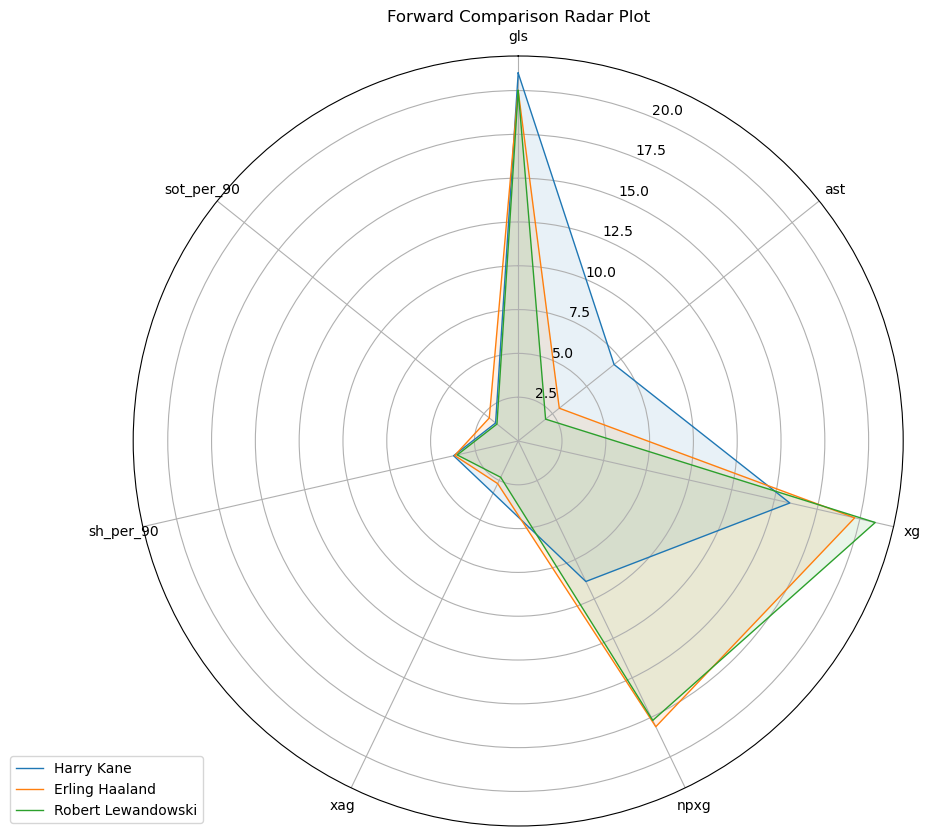

In [45]:
# Create radar plot comparing Harry Kane with other top forwards
import matplotlib.pyplot as plt
import numpy as np

def create_radar_plot(players, metrics):
    # Get data for selected players and metrics
    plot_data = analysis_df[analysis_df['player_x'].isin(players)][['player_x'] + metrics].set_index('player_x')
    
    # Number of variables
    num_vars = len(metrics)
    
    # Compute angle for each axis
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]
    
    # Initialize the spider plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Plot data
    for idx, player in enumerate(players):
        values = plot_data.loc[player].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=player)
        ax.fill(angles, values, alpha=0.1)
    
    # Fix axis to go in the right order and start at 12 o'clock
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw axis lines for each angle and label
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("Forward Comparison Radar Plot")
    
    return fig

# Select metrics for comparison
comparison_metrics = ['gls', 'ast', 'xg', 'npxg', 'xag', 'sh_per_90', 'sot_per_90']

# Select players to compare
players_to_compare = ['Harry Kane', 'Erling Haaland', 'Robert Lewandowski']

# Create and display the radar plot
radar_plot = create_radar_plot(players_to_compare, comparison_metrics)
plt.show()


##### ANalyze How Age affetcts market value 

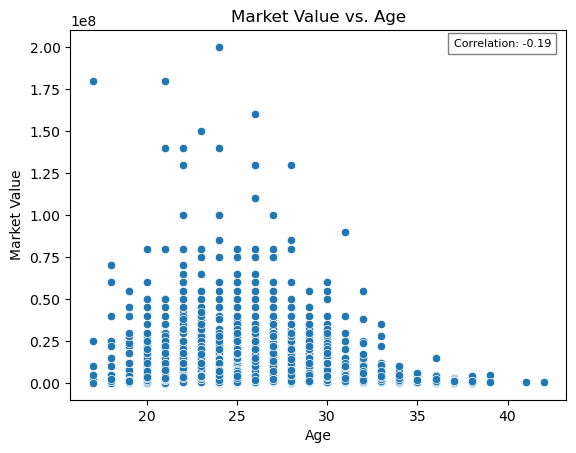

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation coefficient
correlation = analysis_df['age'].corr(analysis_df['value'])

# Create the scatter plot
sns.scatterplot(x='age', y='value', data=analysis_df)
plt.title('Market Value vs. Age')
plt.xlabel('Age')
plt.ylabel('Market Value')

# Add the correlation coefficient as text to the plot
plt.text(x=analysis_df['age'].max() - 5, y=analysis_df['value'].max() - 5, s=f'Correlation: {correlation:.2f}', fontsize=8, bbox=dict(facecolor='white', alpha=0.5))

# Show the plot
plt.show()

The scatter plot shows the relationship between a football player's age and their market value in Euros.

Peak Value Age: Players tend to reach their highest market values in their early to mid-twenties. The most valuable player in the dataset appears to be around 24 years old with a value of €200 million.

Value Decline: There's a clear downward trend in market value as players age, particularly after 30. By age 35, very few players maintain significant market values.

Value Distribution: There's a wide range of values for players in the 20-30 age bracket, with most concentrated in the €10-50 million range.

Value Ceiling: Younger players (18-25) have the highest potential ceiling for market value, with several players valued above €100 million.

Career Trajectory: The overall shape illustrates the typical career value trajectory in football - rising rapidly in early career, peaking in the mid-20s, and then declining gradually after 30.